In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [2]:
import numpy as np
import scipy as sp
import json
import torch
torch.set_default_dtype(torch.float64)
device="cpu"
from equistore import Labels, TensorBlock, TensorMap
from utils.builder import TensorBuilder
import ase.io
from itertools import product
from utils.acdc_mini import acdc_standardize_keys, cg_increment, cg_combine, _remove_suffix
from utils.clebsh_gordan import ClebschGordanReal
from utils.hamiltonians import hamiltonian_features
import matplotlib.pyplot as plt

from utils.librascal import  RascalSphericalExpansion, RascalPairExpansion
from rascal.representations import SphericalExpansion
import copy
from utils.model_hamiltonian import *
from itertools import product
import tqdm.notebook as tqdm

In [3]:
from utils.mp_utils import * 

In [118]:
frames = ase.io.read("./data/random-methane-10k.extxyz",":1000")
# frames2 = ase.io.read("mp_equistore/data/hamiltonian/ethanol-hamiltonian/ethanol_4500.xyz",":1")
# frames3= [ase.build.molecule('NH3')]
for f in frames:
    f.cell = [100,100,100]
    f.positions += 50
energies = torch.tensor([f.info['energy'] for f in frames])
energies -= energies.mean()

In [119]:
rascal_hypers = {
    "interaction_cutoff": 3.5,
    "cutoff_smooth_width": 0.3,
    "max_radial": 6,
    "max_angular": 4,
    "gaussian_sigma_type": "Constant",
    "compute_gradients":  False,
#     "expansion_by_species_method": "user defined",
#     "global_species": [1,6,8,7]
    
}
spex = RascalSphericalExpansion(rascal_hypers)
rhoi = spex.compute(frames)
rho1i = acdc_standardize_keys(rhoi)
rho1i.keys_to_properties(['species_neighbor'])

In [120]:
cg = ClebschGordanReal(5)

In [121]:
gij_hypers = {
    "interaction_cutoff": 3.5,
    "cutoff_smooth_width": 0.3,
    "max_radial": 4,
    "max_angular": 2,
    "gaussian_sigma_type": "Constant",
    "compute_gradients":  False,
#     "expansion_by_species_method": "user defined",
#     "global_species": [1,6,8,7]
}    
pairs = RascalPairExpansion(gij_hypers)
gij = pairs.compute(frames)

In [122]:
gij =  acdc_standardize_keys(gij)

In [123]:
rhoii1i2_nu0 = cg_combine(gij, gij, clebsch_gordan=cg, other_keys_match=['species_center'], lcut=4)

In [124]:
rhoii1i2_nu1 =  cg_combine(rho1i, rhoii1i2_nu0, clebsch_gordan=cg, other_keys_match = ['species_center'], lcut=0, filter_sigma=[1])

In [125]:
len(rhoii1i2_nu1.block(0).properties)

2688

In [126]:
cov = np.zeros((len(rhoii1i2_nu1.block(0).properties), len(rhoii1i2_nu1.block(0).properties)))
for k, b in tqdm.tqdm(rhoii1i2_nu1):
    cov += b.values.squeeze().T@b.values.squeeze()

In [127]:
eva, eve = np.linalg.eigh(cov)

In [128]:
eva = eva[::-1]
eve = eve[:, ::-1]

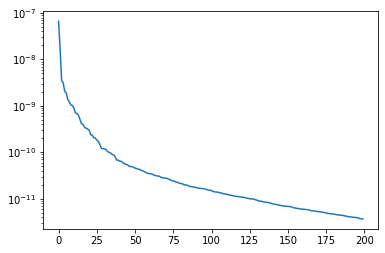

In [129]:
plt.semilogy(eva[:200])

In [130]:
def StructureMap(samples_structure, device="cpu"):
    unique_structures, unique_structures_idx = np.unique(
        samples_structure, return_index=True
    )
    new_samples = samples_structure[np.sort(unique_structures_idx)]
    # we need a list keeping track of where each atomic contribution goes
    # (e.g. if structure ids are [3,3,3,1,1,1,6,6,6] that will be stored as
    # the unique structures [3, 1, 6], structure_map will be
    # [0,0,0,1,1,1,2,2,2]
    replace_rule = dict(zip(unique_structures, range(len(unique_structures))))
    structure_map = torch.tensor(
        [replace_rule[i] for i in samples_structure],
        dtype=torch.long,
        device=device,
    )
    return structure_map, new_samples, replace_rule

def block_compress(block, compress, structure_sel):
    samples = (
        block.samples.view(dtype=np.int32).reshape(-1, len(block.samples.names)).copy()
    )
    if structure_sel is None:
        selected = np.arange(0, len(block.samples))
    else:
        selected = []
        for i in structure_sel:
            selected.append(np.where(block.samples["structure"] == i)[0])
        selected = np.concatenate(selected)
    samples = Labels(block.samples.names, samples[selected])

    new_block = TensorBlock(
        values=torch.tensor(block.values[selected]@compress),
        samples=samples,
        components=block.components,
        properties=Labels(["pca"], np.arange(0, compress.shape[1], dtype=np.int32)[:,np.newaxis]),
    )

    return new_block


def move_and_compress(tensor_map, compress, structure_sel=None):
    blocks = []
    for _, block in tensor_map:
        blocks.append(block_compress(block, compress, structure_sel))

    return TensorMap(tensor_map.keys, blocks)


In [131]:
class NNModel(torch.nn.Module):
    def __init__(self, layer_size=100):
        super().__init__()

        self.nn = None
        self.layer_size = layer_size

    def initialize_model_weights(self, block, seed):
        if seed is not None:
            torch.manual_seed(seed)

        X = block.values

        # initialize nn with zero weights ??
        def init_zero_weights(m):
            if isinstance(m, torch.nn.Linear):
                m.weight.data.fill_(0)
                m.bias.data.fill_(0)

        self.nn = torch.nn.Sequential(
            torch.nn.Linear(X.shape[-1], self.layer_size),
            torch.nn.Tanh(),
            torch.nn.Linear(self.layer_size, self.layer_size),
            torch.nn.Tanh(),
            torch.nn.Linear(self.layer_size, 1),
        )

    def forward(self, block):
        if self.nn is None:
            raise Exception("call initialize_weights first")

        tensor = block.values.squeeze()

        structure_map, new_samples, _ = StructureMap(
            block.samples["structure"], tensor.device
        )
        
        nn_per_triple = self.nn(tensor)
        nn_per_structure = torch.zeros((len(new_samples), 1), device=tensor.device)
        nn_per_structure.index_add_(0, structure_map, nn_per_triple)
        energies = nn_per_structure
        return energies

In [132]:
class NNTriple(torch.nn.ModuleDict):
    
    def __init__(self, species, layer_size=100):
        super().__init__()

        for a,b,c in product(species, species, species):
            self[str((a,b,c))] = NNModel(layer_size)            
    
    def initialize_model_weights(self, descriptor, seed):
        for (_,_,_,a,b,c), block in descriptor:
            self[str((a,b,c))].initialize_model_weights(block, seed)
            
    def forward(self, descriptor):
        first = True
        for (_,_,_,a,b,c), block in descriptor:
            if first:
                energy = self[str((a,b,c))].forward(block)
            else:
                energy += self[str((a,b,c))].forward(block)
        return energy
        

In [133]:
ntrain = 800
rhoii1i2_nu1_train = move_and_compress(rhoii1i2_nu1, 1e7*eve[:,:200], np.arange(0,ntrain)) # also makes the features "large enough" (otherwise it looks like the NN freaks out)
rhoii1i2_nu1_test = move_and_compress(rhoii1i2_nu1, 1e7*eve[:,:200], np.arange(ntrain,len(frames)))

In [134]:
mymodel = NNTriple([1,6])

In [135]:
mymodel.initialize_model_weights(rhoii1i2_nu1_train, seed=12345)

In [136]:
optimizer = torch.optim.LBFGS(
        mymodel.parameters(),
        lr=0.05,
        line_search_fn="strong_wolfe",
        history_size=128,
    )

def loss_mse(predicted, actual):
    return torch.sum((predicted.flatten() - actual.flatten()) ** 2)

In [137]:
n_epochs=100
for epoch in range(0, n_epochs):
    print("Beginning epoch", epoch)
    
    def single_step():
        # global composition, radial_spectrum, spherical_expansions, energies
        optimizer.zero_grad()
        loss = torch.zeros(size=(1,), device=device)
        
        predicted = mymodel(rhoii1i2_nu1_train)
        loss += loss_mse(predicted, energies[:ntrain])
        
        loss.backward(retain_graph=False)
        return loss

    loss = optimizer.step(single_step)
    predicted = mymodel(rhoii1i2_nu1_test)
    
    print("Energy RMSE: train ", np.sqrt(loss.detach().numpy().flatten()[0])/ntrain,
         "test", np.sqrt(loss_mse(predicted, energies[ntrain:]).detach().numpy().flatten()[0])/(len(frames) - ntrain) )

Beginning epoch 0
Energy RMSE: train  0.009777447579161196 test 0.004952675646496161
Beginning epoch 1
Energy RMSE: train  0.002963099005341209 test 0.003954681991392568
Beginning epoch 2
Energy RMSE: train  0.001994856318414432 test 0.00365214936784674
Beginning epoch 3
Energy RMSE: train  0.0019039554920157358 test 0.0036231235642994603
Beginning epoch 4
Energy RMSE: train  0.001889506989489402 test 0.003671715901933111
Beginning epoch 5
Energy RMSE: train  0.0018770738025722196 test 0.0036561723218165865
Beginning epoch 6
Energy RMSE: train  0.0018694617153079455 test 0.0036496418586783623
Beginning epoch 7
Energy RMSE: train  0.0018619542895584767 test 0.0037197202949342057
Beginning epoch 8
Energy RMSE: train  0.0018530733321251568 test 0.003754696305823008
Beginning epoch 9
Energy RMSE: train  0.0018469589055134827 test 0.0037965564270695056
Beginning epoch 10


KeyboardInterrupt: 

([<matplotlib.lines.Line2D at 0x7f705b075f10>],)

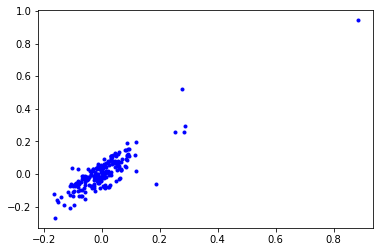

In [138]:
plt.plot(predicted.detach().numpy(), energies[ntrain:], 'b.'),
